# Classifying Planets: Exploring Habitability

## Introduction

In the vast expanse of the cosmos, the search for habitable planets has captivated the imaginations of scientists and explorers alike. As humanity reaches for the stars, our quest to understand the conditions necessary for life beyond Earth has led us to a fascinating challenge: predicting the habitability of distant planets.

In this classification problem, we embark on a journey where we are presented with a synthetic dataset, carefully crafted to simulate various planetary features. Our mission is clear: **discern whether a planet is habitable, probably habitable, or deemed inhospitable to life**.

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Load the data

In [106]:
data_df = pd.read_csv("data/planet_habitability.csv")

## Exploring the data

### Data Field Descriptions

- **planet_habitability.csv** - Synthetic dataset containing planetary features and their corresponding habitability classification. (10'000 per class)

| Feature                              | Description                                                   |
| ------------------------------------ | ------------------------------------------------------------- |
| `Atmospheric Pressure (bar)`         | Average pressure of the planet's atmosphere                   |
| `Magnetic Field Strength (µT)`       | Strength of the planet's magnetic field                       |
| `H2O Traces`                         | Presence of water on the planet                               |
| `Average Radiation Levels (Siverts)` | Average amount of radiation the planet is exposed to per year |
| `Alien Presence Probability`         | Probability of alien life on the planet                       |
| `Solar Flare Frequency (per year)`   | Frequency of solar flares on the planet per year              |
| `Bio-Growth Probability`             | Potential of the planet to support life                       |

In [107]:
data_df.head()

,Atmospheric Pressure (bar),Magnetic Field Strength (µT),H2O Traces,Average Radiation Levels (Siverts),Probability of Alien Presence,Solar Flare Frequency (per year),Bio-Growth Potentiality,Habitability
0,2.433766,0.987060,1,0.966538,0.171071,186.025691,1.193267,1
1,3.084193,0.181359,1,1.726828,0.994699,167.913710,0.277169,1
2,1.683851,0.131489,1,0.187396,0.856885,74.539139,1.717024,1
3,1.396706,2.442122,1,0.087059,0.382788,158.623825,0.673685,1
4,1.529316,0.820420,1,0.263330,0.270811,4.746676,0.449494,1


In [108]:
print('Data shape:', data_df.shape)

data_df.describe(include='all')

Data shape: (30000, 8)


,Atmospheric Pressure (bar),Magnetic Field Strength (µT),H2O Traces,Average Radiation Levels (Siverts),Probability of Alien Presence,Solar Flare Frequency (per year),Bio-Growth Potentiality,Habitability
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000
mean,1.844363,1.278968,0.592800,1.217856,0.449279,83.550276,0.600255,1.00000
std,1.043875,0.775694,0.491321,0.855417,0.272459,60.659197,0.373322,0.81651
min,0.100005,0.010253,0.000000,0.010059,0.000040,0.000126,0.000037,0.00000
25%,0.984362,0.631169,0.000000,0.502823,0.216475,25.447068,0.296006,0.00000
50%,1.770247,1.243347,1.000000,0.974424,0.431587,75.853994,0.578377,1.00000
75%,2.589755,1.829919,1.000000,1.916291,0.673601,136.227390,0.860610,2.00000
max,3.999752,2.999779,1.000000,2.999942,0.999941,199.990449,2.118078,2.00000


## Visualizing the data

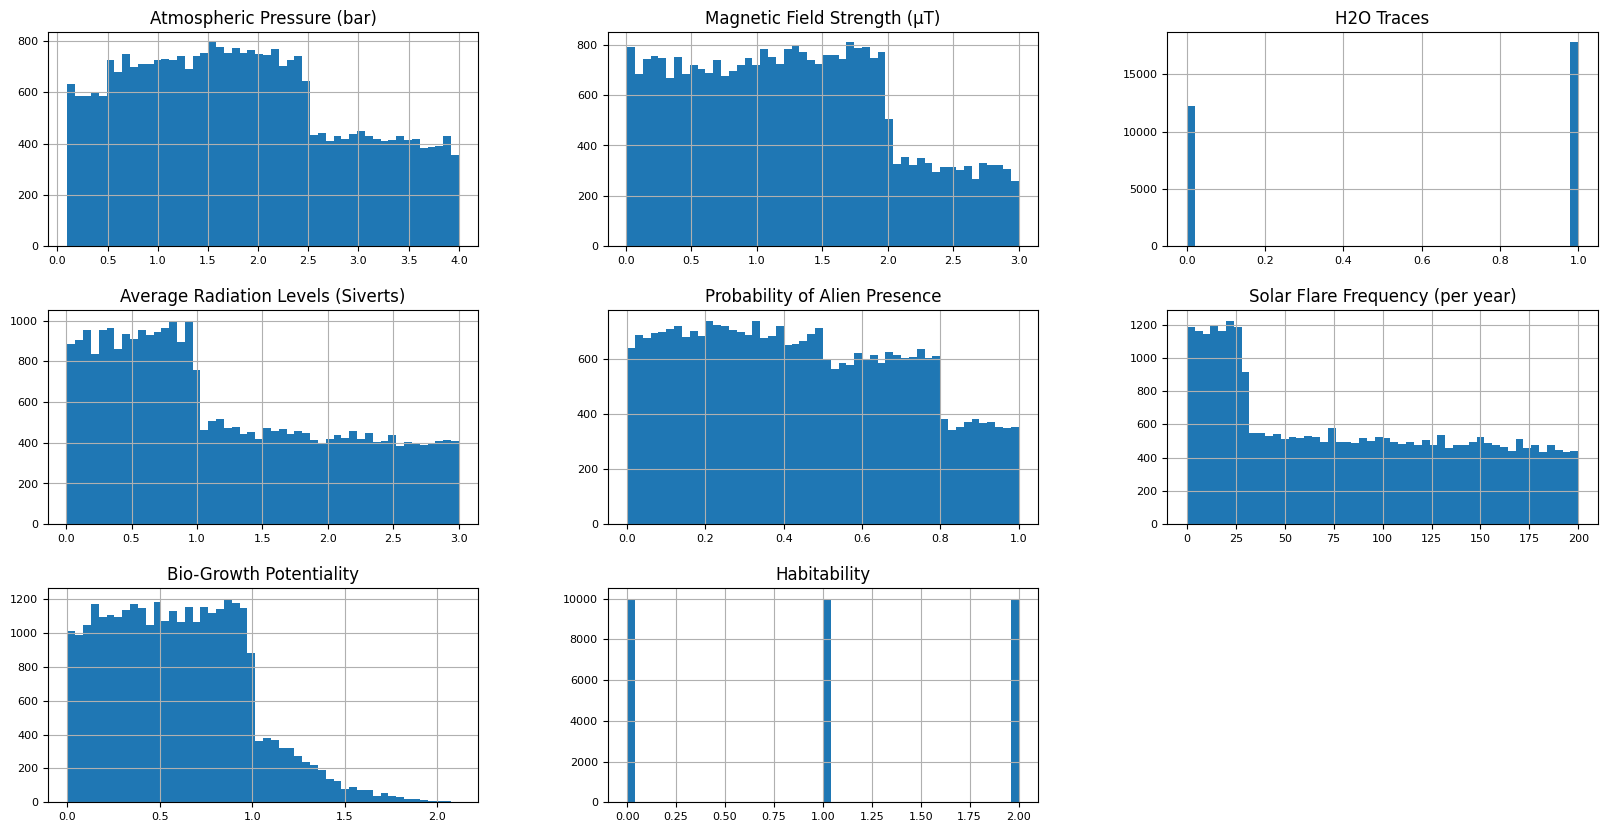

In [109]:
# plot all features
data_df.hist(figsize=(20, 10), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

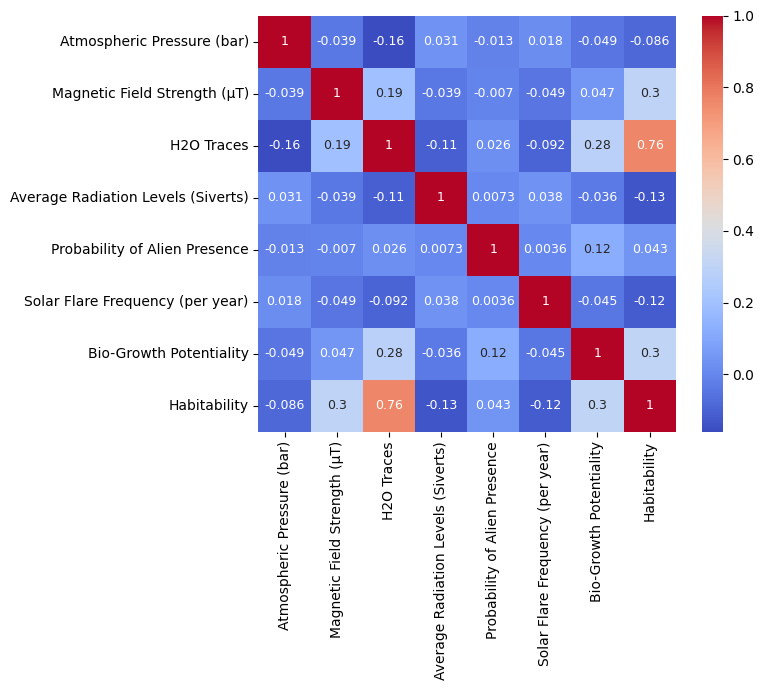

In [110]:
# Plot confusion matrix with plt and df.corr
plt.figure(figsize=(8, 7), tight_layout=True)
sns.heatmap(data_df.corr(), annot=True, annot_kws={"size": 9}, cmap="coolwarm")
plt.show()

## Preparing the data

The following steps are performed to prepare the data:

- Normalizing the data
- Splitting the data into training and validation sets

In [111]:
# Normalize each feature to a range of [0, 1] except the target feature
normalized_df = data_df.copy()

for feature in set(data_df.columns) - set(["Habitability"]):
    normalized_df[feature] = (data_df[feature] - data_df[feature].min()) / (
            data_df[feature].max() - data_df[feature].min()
    )

normalized_df.head()

,Atmospheric Pressure (bar),Magnetic Field Strength (µT),H2O Traces,Average Radiation Levels (Siverts),Probability of Alien Presence,Solar Flare Frequency (per year),Bio-Growth Potentiality,Habitability
0,0.598439,0.326743,1.0,0.319905,0.171048,0.930173,0.563365,1
1,0.765226,0.057235,1.0,0.574193,0.994757,0.839609,0.130844,1
2,0.406141,0.040554,1.0,0.059312,0.856930,0.372713,0.810649,1
3,0.332509,0.813463,1.0,0.025754,0.382786,0.793157,0.318052,1
4,0.366514,0.271002,1.0,0.084709,0.270798,0.023734,0.212204,1


In [112]:
# Split the dataset into features and labels
X = normalized_df.drop(["Habitability"], axis=1).values
y = normalized_df["Habitability"].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (21000, 7) (21000,)
Test set shape: (9000, 7) (9000,)


## Training the model

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

In [114]:
# Train the model
model = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=50, random_state=1)

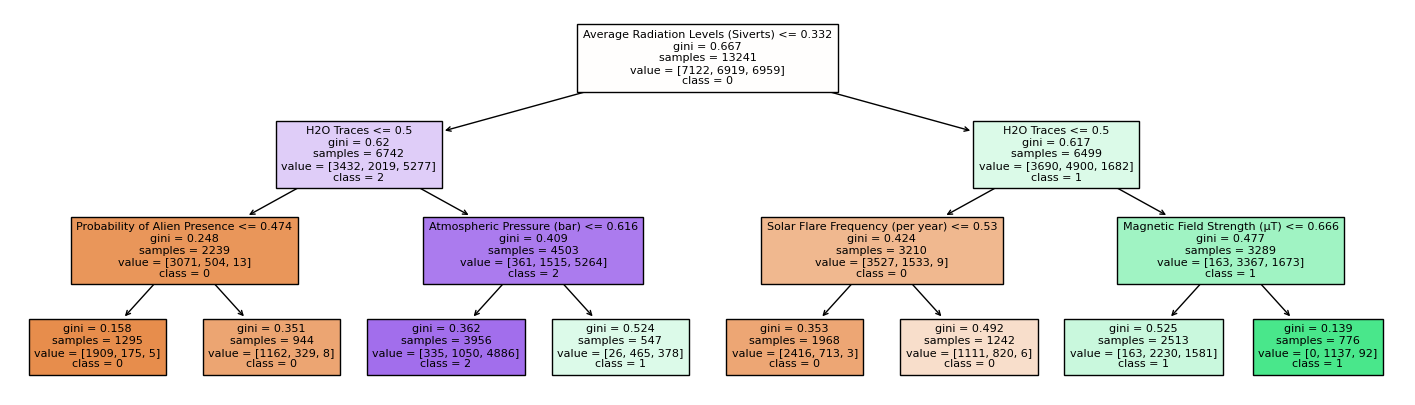

In [115]:
# Visualize the decision tree
plt.figure(figsize=(18, 5))
plot_tree(model.estimators_[0], feature_names=data_df.columns, class_names=["0", "1", "2"], filled=True, fontsize=8)
plt.show()

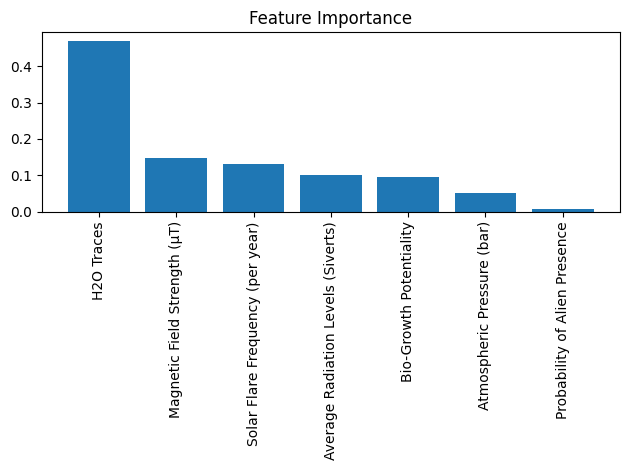

In [116]:
# Calculate feature importances
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [normalized_df.columns[i] for i in indices]

# Create plot
plt.figure(tight_layout=True)
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

## Model Evaluation

In [117]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Test Accuracy: 80.97%
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      3001
           1       0.84      0.62      0.71      3036
           2       0.77      0.89      0.83      2963

    accuracy                           0.81      9000
   macro avg       0.81      0.81      0.80      9000
weighted avg       0.81      0.81      0.80      9000



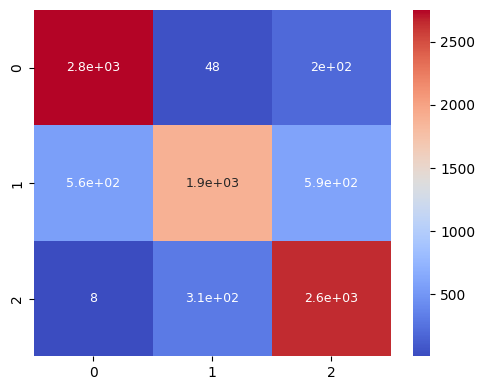

In [118]:
# Predict on test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Calculate classification report
cr = classification_report(y_test, y_pred)
print("Classification Report:\n", cr)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4), tight_layout=True)
sns.heatmap(cm, annot=True, annot_kws={"size": 9}, cmap="coolwarm")
plt.show()

